In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.manifold import TSNE
from itertools import chain
import time
import datetime
import pickle

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

import warnings
warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>

In [2]:
def graph_to_matrix(G,weighted=False,directed=False): # convert a graph object into a matrix
    matrix = np.zeros((len(G.nodes()),len(G.nodes())))
    for edge in G.edges(data=True):
        if weighted:
            matrix[edge[0],edge[1]] = edge[2]['weight']
        else:
            matrix[edge[0],edge[1]] = 1
        if not directed:
            matrix[edge[1],edge[0]] = matrix[edge[0],edge[1]] 
    return matrix
    
def matrix_to_graph(matrix): # convert an adjacency matrix into a graph object
    G = nx.Graph().to_directed()
    for i in range(matrix.shape[0]):
        G.add_node(i)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i,j] != 0:
                G.add_edge(i, j, weight=matrix[i,j])
    return G

def ErdosRenyiGraph(n,p):
    return nx.erdos_renyi_graph(n, p).to_directed(),False

def dRegularGraph(n,d):
    return nx.random_regular_graph(d, n).to_directed(),False

def randomAdjacencyMatrix(n,p,weighted=False,directed=False): #ErdosRenyi is unweighted & undirected
    # matrix is in dimension nxn (i.e. n is the number of nodes)
    # p is probability for having non-zero entries
    # values of non-zero entries are sampled in Unif[0,1) if graph is weighted
    matrix = (np.random.rand(n, n) < p).astype(int)
    np.fill_diagonal(matrix, 0)
    if weighted:
        matrix = matrix * np.random.rand(n, n)
    if not directed:
        for i in range(n):
            for j in range(n):
                matrix[j,i] = matrix[i,j]
    return matrix,directed

def geometricAdjacencyMatrix(n,d,r,metric='euclidean'):
    '''
    Valid values for metric are:
    From scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]. These metrics support sparse matrix inputs. [‘nan_euclidean’] but it does not yet support sparse matrices.
    From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] See the documentation for scipy.spatial.distance for details on these metrics. These metrics do not support sparse matrix inputs.
    '''
    points = np.random.uniform(0, 1, size=(n, d))
    distance_matrix = (pairwise_distances(points, metric=metric) < r).astype(int)
    np.fill_diagonal(distance_matrix, 0)
    return distance_matrix,False

def ChungLuGraph(n,max_degree):
    degrees = np.random.choice(range(1,max_degree+1), n, replace=True)
    G = nx.Graph()
    for node, degree in enumerate(degrees):
        G.add_node(node, degree=degree)
    for u in G.nodes():
        for v in G.nodes():
            if u < v and np.random.rand() < G.nodes[u]['degree'] * G.nodes[v]['degree'] / (2 * sum(degrees)):
                    G.add_edge(u, v)
    return G.to_directed(),False

def gridGraph(nrows,ncols): # not random
    G = nx.Graph()
    for i in range(nrows):
        for j in range(ncols):
            G.add_node(i*ncols+j)
    for i in range(nrows):
        for j in range(ncols):
            if i < nrows - 1:
                G.add_edge(i*ncols+j, (i+1)*ncols+j)
            if j < ncols - 1:
                G.add_edge(i*ncols+j+1, i*ncols+j)
    return G.to_directed(),False

In [20]:
def closestSeed_networkx(G,u,S,return_path=False):
    closest_point = None
    smallest_distance = float('inf')
    shortest_path = []
    for s in S:
        path = nx.shortest_path(G, source=u, target=s, weight="weight")
        distance = sum(G[path[i]][path[i + 1]]["weight"] for i in range(len(path) - 1))
        if distance < smallest_distance:
            closest_point, smallest_distance, shortest_path = path[-1], distance, path            
    if not return_path:
        return closest_point, smallest_distance
    else:
        return closest_point, smallest_distance, shortest_path

#### Das Sarma & Bourgain ####

def closestSeedFromStartPoint(graph, start, target_set, return_path=False):
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    target_set = [x for x in target_set if x != start]
    if len(target_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque([(start, 0, [])])  # Initialize the queue with the starting vertex, its path, and the total weight
        storage = deque() # To store nodes removed from queue

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex not in target_set:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from 'start' to 'neighbor' in queue or storage with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))

            elif vertex in target_set:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed
    
    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def closestSeedToEndPoint(graph, target, start_set, return_path=False): 
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    start_set = [x for x in start_set if x != target]
    if len(start_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque()  # Initialize the queue with the starting vertex, its path, and the total weight
        for i in range(len(start_set)):
            queue.append((start_set[i], 0, []))
        storage = deque()

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex != target:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor not in start_set and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from a start node to 'neighbor' in queue with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))
                                
            else:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed

    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def offlineSample(G,u,node_to_sets=True):
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    if len(support) == 0:
        return set()
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if node_to_sets:
        closest_points = set([closestSeedFromStartPoint(G,u,S) for S in sample_sets])
    else:
        closest_points = set([closestSeedToEndPoint(G,u,S) for S in sample_sets])
    if (None,float('inf')) in closest_points:
        closest_points.remove((None,float('inf')))
    return closest_points,set(np.concatenate(sample_sets))

def offlineSketch(G,u,k,node_to_sets=True):
    closest_points,sample_sets = offlineSample(G,u,node_to_sets)
    for i in range(k):
        closest_points_new,sample_sets_new = offlineSample(G,u,node_to_sets)
        closest_points = closest_points.union(closest_points_new)
        sample_sets = sample_sets.union(sample_sets_new)
    return np.array(list(closest_points)),np.array(list(sample_sets))

def onlineShortestPath_Sarma(G,u,v,k,directed=False): ## upper bound
    if not directed:
        sketch_u,_ = offlineSketch(G,u,k)
        sketch_v,_ = offlineSketch(G,v,k)
    else:
        sketch_u,_ = offlineSketch(G,u,k)
    if sketch_u.shape[0] != 0 and sketch_v.shape[0] != 0:
        common_nodes = [w for w in sketch_u[:,0] if w in sketch_v[:,0]]
        while None in common_nodes:
            common_nodes.remove(None)
        min_dist = float('inf')
        for w in common_nodes:
            dist = sketch_u[sketch_u[:, 0] == w][0,1] + sketch_v[sketch_v[:, 0] == w][0,1]
            if dist < min_dist:
                min_dist = dist
        return min_dist
    else:
        return float('inf')

def onlineShortestPath_Bourgain(G,u,v,directed=False): ## lower bound
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if directed:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        d_S_u = [closestSeedToEndPoint(G,u,S)[1] for S in sample_sets]
        d_S_v = [closestSeedToEndPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        to_remove = [idx for idx,val in enumerate(list(zip(d_S_u,d_S_v))) if val[0] == float('inf') or val[1] == float('inf')]
        d_S_u = np.array([value for index, value in enumerate(d_S_u) if index not in to_remove])
        d_S_v = np.array([value for index, value in enumerate(d_S_v) if index not in to_remove])
        return max([0,np.max(d_S_v-d_S_u),np.max(d_u_S-d_v_S)])
    else:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        return np.max(np.abs(d_u_S-d_v_S))

def shortestDistance_allNodes_Sarma(G,u,k,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Sarma(G,u,v,k,directed)
    return distances

def shortestDistance_allNodes_Bourgain(G,u,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Bourgain(G,u,v,directed)
    return distances

def shortestDistance_allNodes_networkx(G,u):
    if isinstance(G, np.ndarray):
        G = matrix_to_graph(G)
    n_nodes = len(G.nodes())
    distances = np.zeros(n_nodes)
    for v in range(n_nodes):
        if u != v:
            if nx.has_path(G, u, v):
                distances[v] = nx.shortest_path_length(G, u, v)
            else:
                distances[v] = float('inf')       
    return distances

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, out_channels, sigmoid = False, reLU = False):
        super(MLP, self).__init__()
        #torch.manual_seed(12345)
        self.name = 'mlp'
        self.lin1 = Linear(in_channels, hidden_channels1)
        self.lin2 = Linear(hidden_channels1, hidden_channels2)
        self.lin3 = Linear(hidden_channels2, hidden_channels3)
        self.lin4 = Linear(hidden_channels3, out_channels)
        #self.lin5 = Linear(hidden_channels4, hidden_channels5)
        #self.lin6 = Linear(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None
        if reLU:
            self.reLU = torch.nn.ReLU()
        else:
            self.reLU = None

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin5(x)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin6(x)
        if self.sigmoid != None:
            x = self.sigmoid(x)
        if self.reLU != None:
            x = self.reLU(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, out_channels, sigmoid = False, reLU = False):
        super(GCN, self).__init__()
        #torch.manual_seed(1234567)
        self.name = 'gcn'
        self.conv1 = GCNConv(in_channels, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.conv4 = GCNConv(hidden_channels3, out_channels)
        #self.conv5 = GCNConv(hidden_channels4, hidden_channels5)
        #self.conv6 = GCNConv(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv5(x, edge_index)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv6(x, edge_index)
        if self.sigmoid == None:
            return x
        else:
            return self.sigmoid(x)

def build(n, model_type,criterion_type,optimizer_type,scheduler_type=None):
    if model_type == 'mlp':
        if criterion_type == 'bce':
            model = MLP(n,12,8,4,2,sigmoid = True)
        elif criterion_type in ['mse','l2','l1']: 
            model = MLP(n,12,8,4,1,reLU = True)
        else:
            model = MLP(n,12,8,4,2)
    elif model_type == 'gcn':
        if criterion_type == 'bce':
            model = GCN(n,12,8,4,2,sigmoid = True)
        elif criterion_type in ['mse','l2','l1']: 
            model = GCN(n,12,8,4,1,reLU = True)
        else:
            model = GCN(n,12,8,4,2)
    else:
        raise ValueError(
            "Model type not yet defined."
        )
    
    if criterion_type == 'ce':
        criterion = torch.nn.CrossEntropyLoss()
    elif criterion_type == 'bce':
        criterion = torch.nn.BCELoss()
    elif criterion_type in ['mse','l2']:
        criterion = torch.nn.MSELoss()
    elif criterion_type == 'l1':
        criterion = torch.nn.L1Loss()
    else:
        raise ValueError(
            "Criterion type not yet defined."
        )
    
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
    elif optimizer_type == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.0001, alpha=0.99, eps=1e-8, momentum=0.9)
    elif optimizer_type == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.0001, lr_decay=0.0001)
    else:
        raise ValueError(
            "Optimizer type not yet defined."
        )
    
    if scheduler_type == None:
        scheduler = None
    else:
        if scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        elif scheduler_type == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)
        elif scheduler_type == 'exponential':
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        elif scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        elif scheduler_type == 'cyclic':
            if optimizer_type in ['sgd','rmsprop']:
                scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=True)
            else:
                scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False)
        else:
            raise ValueError(
                "Scheduler type not yet defined."
            )
        
    print(model)
    return model,criterion,optimizer,scheduler

In [5]:
def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index=None):
    t_loss = 0
    total_samples = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:0')
                    y = y.to('cuda:0')
                out = model(x)  # Perform a single forward pass.
                if criterion_type == 'bce':
                    y = torch.stack((1-y, y)).T.to(torch.float32)
                    y_true.extend(y[:,1])
                else:
                    y_true.extend(y)
                t_loss += criterion(out, y)
                total_samples += 1
                pred = out.argmax(dim=1) #  Use the class with highest probability.
                y_pred.extend(pred)
        else:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:0')
                    y = y.to('cuda:0')
                    edge_index = edge_index.to('cuda:0')
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type == 'bce':
                    y = torch.stack((1-y, y)).T.to(torch.float32)
                    y_true.extend(y[:,1])
                else:
                    y_true.extend(y)
                t_loss += criterion(out, y)
                total_samples += 1
                pred = out.argmax(dim=1) #  Use the class with highest probability.
                y_pred.extend(pred)
    t_loss = t_loss/total_samples
    t_loss = t_loss.cpu()
    y_true = [y.cpu() for y in y_true]
    y_pred = [y.cpu() for y in y_pred]
    if criterion_type in ['mse','l2']:
        return t_loss, np.mean((np.array(y_true) - np.array(y_pred)) ** 2), None, None
    elif criterion_type == 'l1':
        return t_loss, np.mean(np.abs(np.array(y_true) - np.array(y_pred))), None, None
    else:
        t_accuracy = sum(np.array(y_true) == np.array(y_pred))/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:0')
                y = y.to('cuda:0')
            out = model(x)  # Perform a single forward pass.
            if criterion_type == 'bce':
                y = torch.stack((1-y, y)).T.to(torch.float32)
            t_loss = criterion(out, y)  # Compute the loss solely based on the training nodes.
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:0')
                y = y.to('cuda:0')
                edge_index = edge_index.to('cuda:0')
            out = model(x,edge_index)  # Perform a single forward pass.
            if criterion_type == 'bce':
                y = torch.stack((1-y, y)).T.to(torch.float32)
            t_loss = criterion(out, y)  # Compute the loss solely based on the training nodes.
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy_or_error, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train)
    v_loss, v_accuracy_or_error, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler.step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler.step(v_loss)

    return train_loss,train_accuracy_or_error,train_sensitivity,train_specificity,v_loss,v_accuracy_or_error,v_sensitivity,v_specificity

def visualizeTNSE(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="")
    plt.show()

def run(samples,model_type,criterion_type,optimizer_type,scheduler_type,num_epochs,visualize = False,save_model = False):   

    gpu_bool = torch.cuda.is_available()

    x_train = samples[0]
    x_val = samples[1]
    x_test = samples[2]
    y_train = samples[3]
    y_val = samples[4]
    y_test = samples[5]
    edge_index_train = samples[6]
    edge_index_val = samples[7]
    edge_index_test = samples[8]
    model,criterion,optimizer,scheduler = build(x_train[0].shape[0], model_type,criterion_type,optimizer_type,scheduler_type)

    if gpu_bool:
        model = model.to('cuda:0')
        
    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    train_loss = []
    train_acc_or_error = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc_or_error = []
    val_sen = []
    val_spec = []
    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            t_loss,t_acc_or_error,t_sen,t_spec, v_loss, v_acc_or_error, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            t_loss,t_acc_or_error,t_sen,t_spec, v_loss, v_acc_or_error, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val)
        train_loss.append(t_loss)
        train_acc_or_error.append(t_acc_or_error)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc_or_error.append(v_acc_or_error)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2']:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training MSE: {t_acc_or_error:.4f}, Validation Loss: {v_loss:.4f}, Validation MSE: {v_acc_or_error:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training MAE: {t_acc_or_error:.4f}, Validation Loss: {v_loss:.4f}, Validation MAE: {v_acc_or_error:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc_or_error:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc_or_error:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

    if model_type == 'mlp':
        test_loss, test_acc_or_error, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc_or_error, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test)
    if criterion_type in ['mse','l2']:
        print(f'Test Loss: {test_loss:03f}, Test MSE: {test_acc_or_error:03f}')
    elif criterion_type == 'l1':
        print(f'Test Loss: {test_loss:03f}, Test MAE: {test_acc_or_error:03f}')
    else:
        print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc_or_error:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    if criterion_type in ['mse','l2','l1']:
        plt.plot(range(1, num_epochs+1), train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), val_loss, color = '#ff7f0e', label = 'validation loss', alpha = 0.6)
        if criterion_type == 'l1':
            plt.plot(range(1, num_epochs+1), train_acc_or_error, color = '#2ca02c', label = 'training mae', alpha = 0.6)
            plt.plot(range(1, num_epochs+1), train_acc_or_error, color = '#d62728', label = 'validation mae', alpha = 0.6)
        else:
            plt.plot(range(1, num_epochs+1), train_acc_or_error, color = '#2ca02c', label = 'training mse', alpha = 0.6)
            plt.plot(range(1, num_epochs+1), train_acc_or_error, color = '#d62728', label = 'validation mse', alpha = 0.6)
        plt.xlabel("epoch")
        plt.ylabel("")
        plt.title("training results")
        plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))
        plt.show()
    else:
        plt.plot(range(1, num_epochs+1), train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), train_acc_or_error, color = '#ff7f0e', label = 'training accuracy', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), train_sen, color = '#2ca02c', label = 'training sensitivity', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), train_spec, color = '#d62728', label = 'training specificity', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), val_loss, color = '#9467bd', label = 'validation loss', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), train_acc_or_error, color = '#8c564b', label = 'validation accuracy', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), val_sen, color = '#e377c2', label = 'validation sensitivity', alpha = 0.6)
        plt.plot(range(1, num_epochs+1), val_spec, color = '#7f7f7f', label = 'validation specificity', alpha = 0.6)
        plt.xlabel("epoch")
        plt.ylabel("")
        plt.title("training results")
        plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))
        plt.show()

    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    model = model.to('cpu')
    if save_model:
        current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        torch.save(model, f"model_{current_datetime}.pth")
    if criterion_type in ['mse','l2','l1']:
        return [model, test_acc_or_error, np.min(val_acc_or_error)]
    else:
        return [model, test_acc_or_error, test_sen, test_spec, np.max(val_acc_or_error), np.max(val_sen), np.max(val_spec)]

In [6]:
def predict(gpu_bool,model,samples_x,samples_edge_index=None):
    y_pred = np.zeros((len(samples_x),samples_x[0].shape[0]))
    if gpu_bool:
        model = model.to('cuda:0')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:0')
                else:
                    x = samples_x[i]
                out = model(x)  # Perform a single forward pass.
                y_pred[i] = out.argmax(dim=1).cpu() #  Use the class with highest probability.
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:0')
                    edge_index = samples_edge_index[i].to('cuda:0')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                out = model(x,edge_index)  # Perform a single forward pass.
                y_pred[i] = out.argmax(dim=1).cpu() #  Use the class with highest probability.
    model = model.to('cpu')
    return y_pred

def predict_allBatches(model,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict(gpu_bool, model, samples[0], samples[6])
    y_pred_val = predict(gpu_bool, model, samples[1], samples[7])
    y_pred_test = predict(gpu_bool, model, samples[2], samples[8])
    return y_pred_train,y_pred_val,y_pred_test

In [7]:
def evaluate_inner(x_samples,true_distances,y_actual,y_pred,title,classification=True):

    if classification:

        graph_size = true_distances.shape[1]

        ## Calculate the proportion of points selected from the sample.
        ratio1 = np.mean(y_pred,axis=1)

        ## Check if any disconnected node is in actual sketch.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        M = np.max(true_distances) * 10
        true_distances[true_distances == -1] = M
        y_actual = torch.stack(y_actual).detach().numpy()
        dump_actual = y_actual*true_distances
        n_dump_actual_equal_M = np.sum((dump_actual == M).astype(int),axis=1)
        ratio2 = n_dump_actual_equal_M/np.sum(y_actual,axis=1) ## nan means empty sketch
        #ratio2[np.isnan(ratio2)] = -1

        ## Check if any disconnected node is chosen.
        dump = y_pred*true_distances
        n_true_distances_equal_M = np.sum((true_distances == M).astype(int),axis=1)
        n_dump_equal_M = np.sum((dump == M).astype(int),axis=1)
        n_selected = np.sum(y_pred,axis=1)
        n_selected[n_selected == 0] = 0.0001
        ratio3 = n_dump_equal_M/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio3[np.isnan(ratio3)] = -1

        ## Seed node and neighbors -> 1. Others -> 0
        seed_or_neighbors = np.zeros_like(true_distances)
        _,seeds = np.where(true_distances == 0) ## number of seeds = number of samples because we selected one seed from each sample
        seed_disconnected = np.zeros(seed_or_neighbors.shape[0])
        for i in range(len(seeds)):
            seed = seeds[i]
            seed_or_neighbors[i] = x_samples[i].detach().numpy()[seed]
            seed_disconnected[i] = sum((seed_or_neighbors[i]>0).astype(int))>0
            seed_or_neighbors[i,seed] = 1
        seed_or_neighbors_selected = seed_or_neighbors*y_pred

        ## Is seed node not disconnected from the remaining?
        seed_disconnected = seed_disconnected.astype(int)

        ## Have seed node and its neighbors been chosen?
        ratio4 = np.sum(seed_or_neighbors_selected,axis=1)/np.sum(seed_or_neighbors,axis=1)

        ## How many of the chosen nodes are seed node and its neighbors?
        ratio5 = np.sum(seed_or_neighbors_selected,axis=1)/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio5[np.isnan(ratio5)] = -1

        ## Check if the chosen nodes are closer than random selection.
        sum_distance_selected = np.sum(dump,axis=1)
        term0 = np.mean(true_distances,axis=1)
        term0[term0 == 0] = 0.0001
        ratio6 = sum_distance_selected/n_selected/term0 ## nan means no nodes have been selected, ratio1 = 0
        #ratio6[np.isnan(ratio6)] = -1

        ## Same as ratio3 but excludes disconnected nodes with inf distance to the seed node.
        n_selected[n_selected == 0.0001] = 0
        term1 = n_selected-n_dump_equal_M
        term1[term1 == 0] = 0.0001
        term2 = np.sum(true_distances,axis=1)-n_true_distances_equal_M*M
        term2[term2 == 0] = 0.0001
        ratio7 = (sum_distance_selected-n_dump_equal_M*M)/term1/term2*(graph_size-n_true_distances_equal_M)
        #ratio7[np.isnan(ratio7)] = -1
        ## nan means no nodes have been selected (ratio1 = 0) or selected nodes are all disconnected from seed node (inf distance)

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(ratio1)), ratio1, color = '#1f77b4', label = 'ratio 1: size of selected community to size of sample ratio',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio2, color = '#ff7f0e', label = 'ratio 2: proportion of disconnected nodes in actual sketch',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio3, color = '#2ca02c', label = 'ratio 3: proportion of disconnected nodes in the chosen community',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio4, color = '#d62728', label = 'ratio 4: proportion of seed node and its neighbors that are selected',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio5, color = '#9467bd', label = 'ratio 5: proportion of selected nodes that are seed node or its neighbors',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio6, color = '#8c564b', label = 'ratio 6: mean distance of chosen nodes to seed node divided by mean distance of all nodes to seed node',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio7, color = '#e377c2', label = 'ratio 7: same as ratio 6 but excludes disconnected nodes',alpha = 0.6)
        plt.scatter(range(len(ratio1)), seed_disconnected, color = 'k', marker='x', label = 'is seed node not disconnected from the remaining nodes in graph? 1 = True, 0 = False',alpha = 0.6)
        plt.xlabel("sample index")
        plt.ylabel("")
        plt.title(title)
        plt.legend(loc = 'lower center',bbox_to_anchor=(0.48, -0.6))
        plt.show()

        true_distances[true_distances == M] = np.inf
        return [np.mean(ratio1),np.mean(ratio2),np.mean(ratio3),np.mean(ratio4),np.mean(ratio5),np.mean(ratio6),np.mean(ratio7)]
        
    else:
        
        ## Calculate prediction to true distance ratio.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        y_pred[y_pred == np.inf] = -1
        M = max(np.max(true_distances),np.max(y_pred))*10
        true_distances[true_distances == -1] = M
        true_distances[true_distances == 0] = 0.0001 ## to avoid ratio = x/0
        y_pred[y_pred == -1] = M
        ratio = (y_pred/true_distances).flatten()
        
        if len(np.unique(ratio)) == 1:
            print('Prediction to true distance ratio is '+str(ratio[0])+' for all samples in '+title+'.')
        else:
            plt.hist(ratio,density=False)
            plt.xlabel("prediction to true distance ratio")
            plt.ylabel("frequency")
            plt.title(title)
            plt.show()
            print('mean ratio = ',np.mean(ratio))

        true_distances[true_distances == M] = np.inf
        true_distances[true_distances == 0.0001] = 0
        y_pred[y_pred == M] = np.inf

        return [np.mean(ratio)]
    
def evaluate(model,samples,classification = True):
    y_pred_train,y_pred_val,y_pred_test = predict_allBatches(model,samples)
    stats = []
    stats.append(evaluate_inner(samples[0],samples[9],samples[3],y_pred_train,'training data',classification))
    stats.append(evaluate_inner(samples[1],samples[10],samples[4],y_pred_val,'validation data',classification))
    stats.append(evaluate_inner(samples[2],samples[11],samples[5],y_pred_test,'test data',classification))
    return np.array(stats)

### Revised

In [8]:
def generateSamples_shortestPath_inner(n_samples,max_n_samples_per_graph,function,*args,**kwargs): ## max_n_samples_per_graph <= n
    samples_x = []
    samples_y = []
    samples_edge_index = []
    object,directed = function(*args,**kwargs)
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    k = len(object.nodes())
    i = 0
    while i<n_samples:
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            selected_pairs = []
            while i<n_samples and j<max_n_samples_per_graph: 
                selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                nodes = list(np.random.choice(list(selected_component), size=2, replace=False))
                if nodes not in selected_pairs and [nodes[1],nodes[0]] not in selected_pairs: ## avoid the same nodes to be selected again
                    path = nx.shortest_path(object, nodes[0], nodes[1], weight="weight")
                    #print('Ground truth shortest path:',path)
                    samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                    samples_y.append(torch.tensor([int(node in path) for node in range(0,k)]).to(torch.int64))
                    samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                    i += 1
                j += 1
        else:
            object,directed = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index

def generateSamples_shortestPath(n_train,n_val,n_test,max_n_samples_per_graph,function,*args,**kwargs):
    x_train, y_train, edge_index_train = generateSamples_shortestPath_inner(n_train,max_n_samples_per_graph,function,*args,**kwargs)
    x_val, y_val, edge_index_val = generateSamples_shortestPath_inner(n_val,max_n_samples_per_graph,function,*args,**kwargs)
    x_test, y_test, edge_index_test = generateSamples_shortestPath_inner(n_test,max_n_samples_per_graph,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test]

In [9]:
def generateSamples_sketch_classification_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y = []
    samples_edge_index = []
    object,directed = function(*args,**kwargs)
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    k = len(object.nodes())
    true_distances = np.zeros((n_samples,k))
    i = 0
    while i<n_samples:
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            while i<n_samples and j<max_n_samples_per_graph:
                n_err = 0
                while True:
                    try:
                        selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                        node = np.random.choice(list(selected_component))
                        sketch,sample_sets = offlineSketch(matrix_type,node,k)
                        break
                    except:
                        n_err += 1
                        if n_err == 100:
                            if i == 0:
                                raise ValueError(
                                    "Did not succesfully generate any sample."
                                )
                            else:
                                raise ValueError(
                                    "Took too long to generate the full set of samples."
                                )
                        continue
                if sketch.shape[0] != 0:
                    true_distances[i] = shortestDistance_allNodes_networkx(object,node)
                    #samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                    samples_x.append(torch.tensor(np.diag(np.array([int(node in sample_sets) for node in range(0,k)])).astype(np.float32), requires_grad=True))
                    sketch = np.append(sketch[:,0],node)
                    samples_y.append(torch.tensor([int(node in sketch) for node in range(0,k)]).to(torch.int64))
                    samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                    i += 1
                j += 1
        else:
            object,directed = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index, true_distances

def generateSamples_sketch_classification(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y_train, edge_index_train, true_distances_train = generateSamples_sketch_classification_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y_val, edge_index_val, true_distances_val = generateSamples_sketch_classification_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y_test, edge_index_test,true_distances_test = generateSamples_sketch_classification_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,true_distances_train,true_distances_val,true_distances_test]

In [10]:
def generateSamples_sketch_regression_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y = []
    samples_edge_index = []
    object,directed = function(*args,**kwargs)
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    k = len(object.nodes())
    true_distances = np.zeros((n_samples,k))
    i = 0
    while i<n_samples:
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            while i<n_samples and j<max_n_samples_per_graph:
                n_err = 0
                while True:
                    try:
                        selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                        node = np.random.choice(list(selected_component))
                        sketch,sample_sets = offlineSketch(matrix_type,node,k)
                        break
                    except:
                        n_err += 1
                        if n_err == 100:
                            if i == 0:
                                raise ValueError(
                                    "Did not succesfully generate any sample."
                                )
                            else:
                                raise ValueError(
                                    "Took too long to generate the full set of samples."
                                )
                        continue
                if sketch.shape[0] != 0:
                    true_distances[i] = shortestDistance_allNodes_networkx(object,node)
                    #samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                    samples_x.append(torch.tensor(np.diag(np.array([int(node in sample_sets) for node in range(0,k)])).astype(np.float32), requires_grad=True))
                    y = np.zeros(k)
                    for n in range(sketch.shape[0]):
                        y[int(sketch[n,0])] = sketch[n,1]
                    samples_y.append(torch.tensor(y).to(torch.float32))
                    samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                    i += 1
                j += 1
        else:
            object,directed = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index, true_distances

def generateSamples_sketch_regression(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y_train, edge_index_train, true_distances_train= generateSamples_sketch_regression_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y_val, edge_index_val, true_distances_val = generateSamples_sketch_regression_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y_test, edge_index_test, true_distances_test = generateSamples_sketch_regression_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,true_distances_train,true_distances_val,true_distances_test]

0.03485751152038574
MLP(
  (lin1): Linear(in_features=25, out_features=12, bias=True)
  (lin2): Linear(in_features=12, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=4, bias=True)
  (lin4): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.4479, Training Accuracy: 0.8272, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4275, Validation Accuracy: 0.8448, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.4411, Training Accuracy: 0.8272, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4209, Validation Accuracy: 0.8448, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.4363, Training Accuracy: 0.8272, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4173, Validation Accuracy: 0.8448, Validation Sensitivity: 0.0000, Validation Specificity: 1

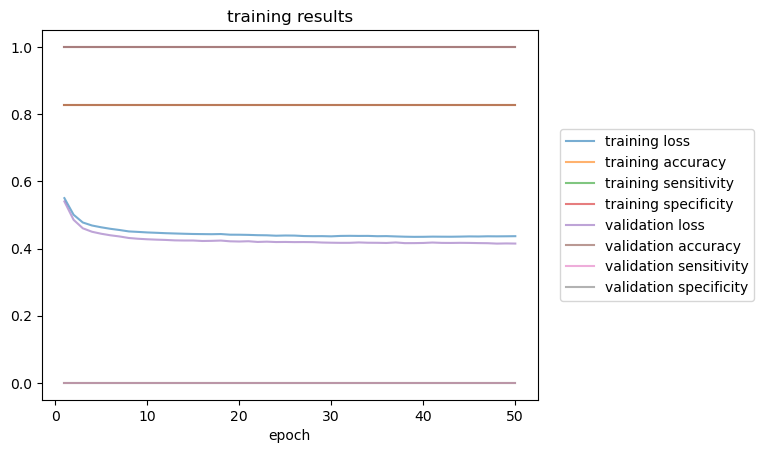

[MLP(
  (lin1): Linear(in_features=25, out_features=12, bias=True)
  (lin2): Linear(in_features=12, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=4, bias=True)
  (lin4): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
), 0.8312, 0.0, 1.0, 0.8448, 0.0, 1.0]
GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.4638, Training Accuracy: 0.8272, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4342, Validation Accuracy: 0.8448, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.4568, Training Accuracy: 0.8272, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4255, Validation Accuracy: 0.8448, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.4565, Training Accuracy: 0.8272, Training Sensitivity

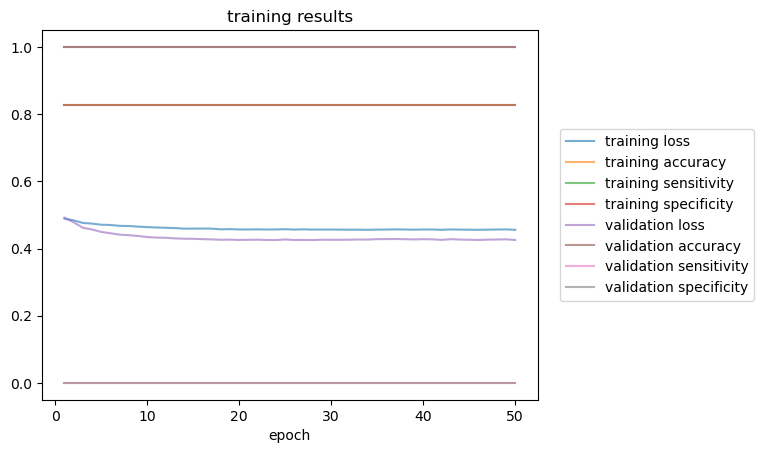

[GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
), 0.8312, 0.0, 1.0, 0.8448, 0.0, 1.0]


In [11]:
t1 = time.time()
samples = generateSamples_shortestPath(200,50,50,10,ErdosRenyiGraph,25,0.1)
t2 = time.time()
print(t2-t1)
results = run(samples,'mlp','bce','adam','cyclic',50)
print(results)
results = run(samples,'gcn','bce','adam','cyclic',50)
print(results)

0.03103947639465332
MLP(
  (lin1): Linear(in_features=20, out_features=12, bias=True)
  (lin2): Linear(in_features=12, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=4, bias=True)
  (lin4): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


Epoch: 010, Training Loss: 0.4641, Training Accuracy: 0.7635, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.5196, Validation Accuracy: 0.7930, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.4409, Training Accuracy: 0.7635, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.5896, Validation Accuracy: 0.7930, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.4358, Training Accuracy: 0.7635, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.6242, Validation Accuracy: 0.7930, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 040, Training Loss: 0.4287, Training Accuracy: 0.7635, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.6731, Validation Accuracy: 0.7930, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 050, Training Loss: 0.4215, Training 

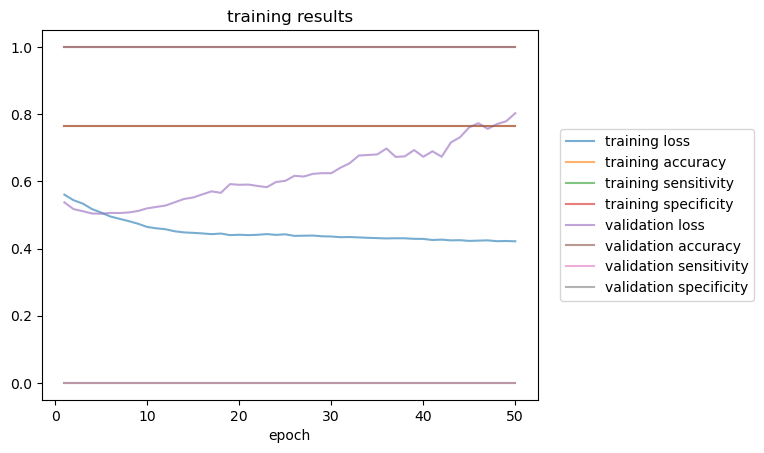

[MLP(
  (lin1): Linear(in_features=20, out_features=12, bias=True)
  (lin2): Linear(in_features=12, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=4, bias=True)
  (lin4): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
), 0.9, 0.0, 1.0, 0.793, 0.0, 1.0]
GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.4973, Training Accuracy: 0.7635, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.5168, Validation Accuracy: 0.7930, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.4800, Training Accuracy: 0.7635, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.5155, Validation Accuracy: 0.7930, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.4719, Training Accuracy: 0.7635, Training Sensitivity: 0.

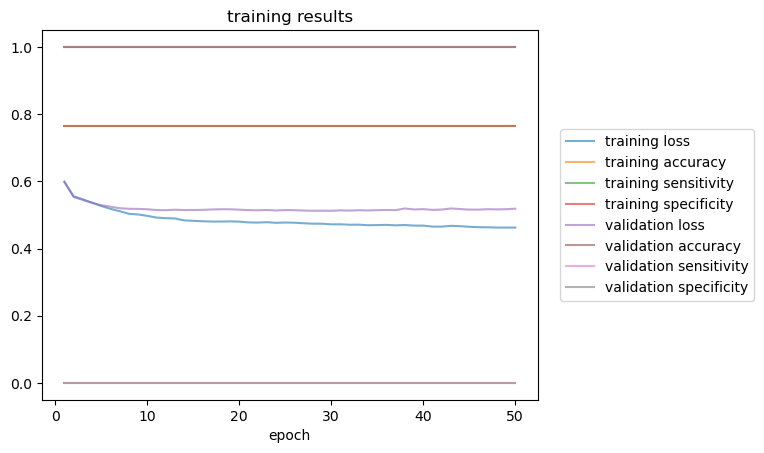

[GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
), 0.9, 0.0, 1.0, 0.793, 0.0, 1.0]


In [12]:
t1 = time.time()
samples = generateSamples_shortestPath(200,50,50,10,randomAdjacencyMatrix,20,0.1,True,True)
t2 = time.time()
print(t2-t1)
results = run(samples,'mlp','bce','adam','cyclic',50)
print(results)
results = run(samples,'gcn','bce','adam','cyclic',50)
print(results)

0.029103517532348633
MLP(
  (lin1): Linear(in_features=20, out_features=12, bias=True)
  (lin2): Linear(in_features=12, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=4, bias=True)
  (lin4): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2511, Training Accuracy: 0.8708, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.8032, Validation Accuracy: 0.8670, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.2529, Training Accuracy: 0.8708, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 1.4774, Validation Accuracy: 0.8670, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.2541, Training Accuracy: 0.8708, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 4.3087, Validation Accuracy: 0.8670, Validation Sensitivity: 0.0000, Validation Specificity: 

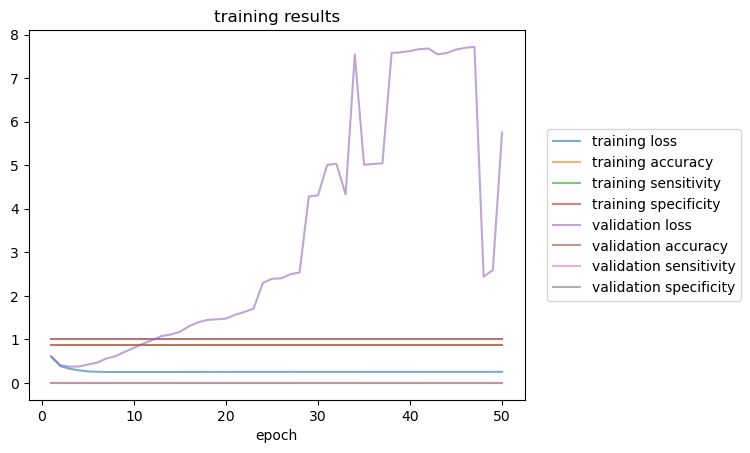

[MLP(
  (lin1): Linear(in_features=20, out_features=12, bias=True)
  (lin2): Linear(in_features=12, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=4, bias=True)
  (lin4): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
), 0.858, 0.0, 1.0, 0.867, 0.0, 1.0]
GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2523, Training Accuracy: 0.8708, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4761, Validation Accuracy: 0.8670, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.2528, Training Accuracy: 0.8708, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4955, Validation Accuracy: 0.8670, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.2514, Training Accuracy: 0.8708, Training Sensitivity: 

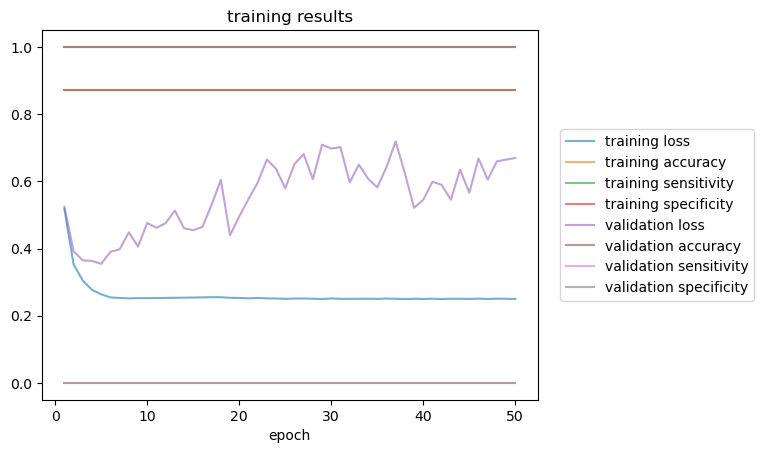

[GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
), 0.858, 0.0, 1.0, 0.867, 0.0, 1.0]


In [13]:
t1 = time.time()
samples = generateSamples_shortestPath(200,50,50,10,ChungLuGraph,20,3)
t2 = time.time()
print(t2-t1)
results = run(samples,'mlp','bce','adam','cyclic',50)
print(results)
results = run(samples,'gcn','bce','adam','cyclic',50)
print(results)

0.7446789741516113
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.3173, Training Accuracy: 0.9030, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.3755, Validation Accuracy: 0.8733, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 020, Training Loss: 0.3170, Training Accuracy: 0.9030, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.3776, Validation Accuracy: 0.8733, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 030, Training Loss: 0.3176, Training Accuracy: 0.9030, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.3780, Validation Accuracy: 0.8733, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 040, Training Loss: 0.3175, Training Accuracy: 0.9030, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validatio

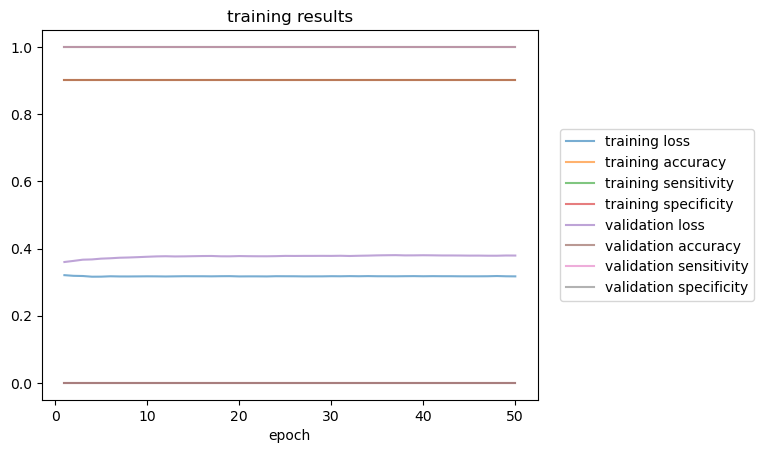

[GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
), 0.9106666666666666, 1.0, 0.0, 0.8733333333333333, 1.0, 0.0]


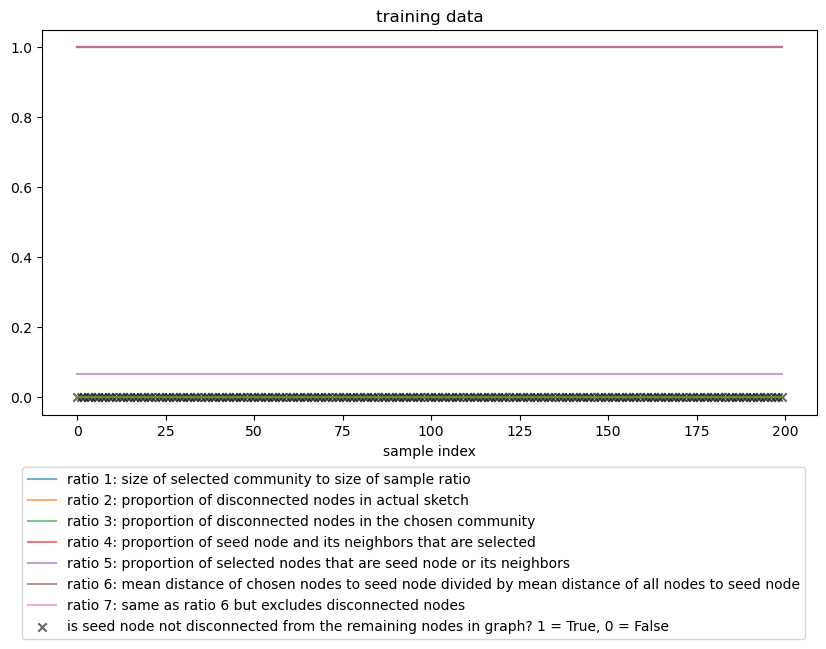

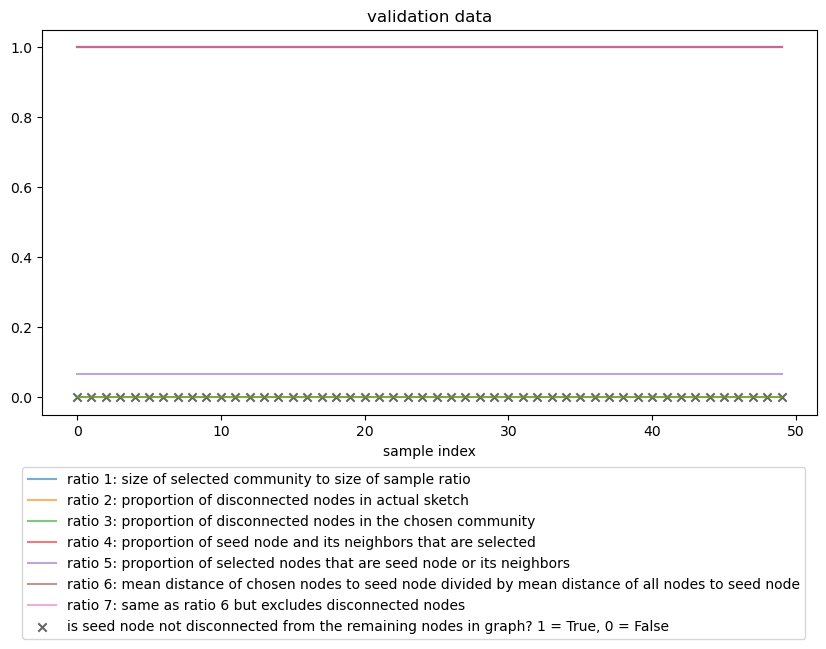

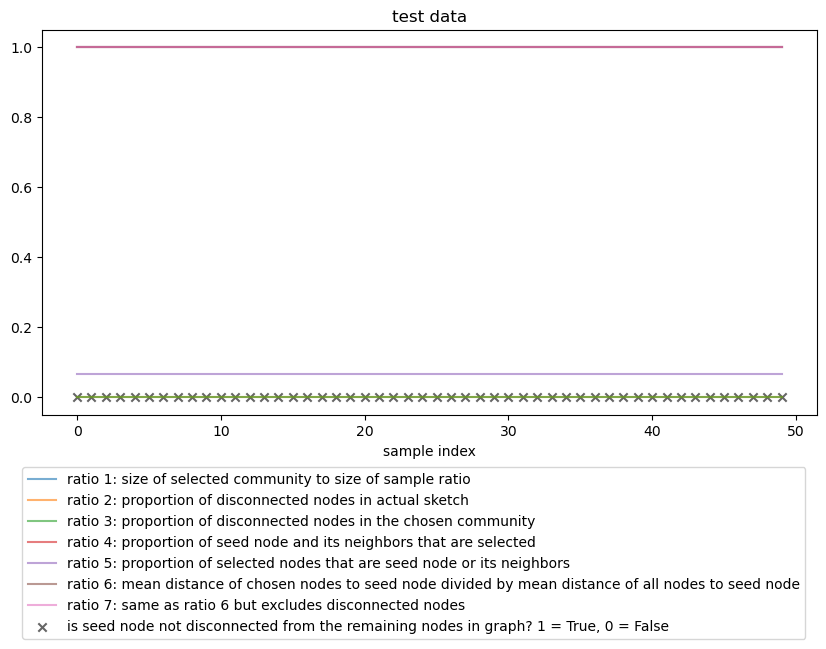

[[1.         0.         0.         1.         0.06666667 1.
  1.        ]
 [1.         0.         0.         1.         0.06666667 1.
  1.        ]
 [1.         0.         0.         1.         0.06666667 1.
  1.        ]]


In [21]:
t1 = time.time()
samples = generateSamples_sketch_classification(200,50,50,10,4,ErdosRenyiGraph,15,0.3)
t2 = time.time()
print(t2-t1)
#results = run(samples,'mlp','bce','adam',None,50)
#print(results)
#stats = evaluate(results[0],samples,classification=True)
#print(stats)

results = run(samples,'gcn','bce','adam',None,50)
print(results)
stats = evaluate(results[0],samples,classification=True)
print(stats)

4.422492742538452
GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.4266, Training Accuracy: 0.8226, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.4188, Validation Accuracy: 0.8560, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 020, Training Loss: 0.4205, Training Accuracy: 0.8226, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.4636, Validation Accuracy: 0.8560, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 030, Training Loss: 0.4215, Training Accuracy: 0.8226, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.4358, Validation Accuracy: 0.8560, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 040, Training Loss: 0.4198, Training Accuracy: 0.8226, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation

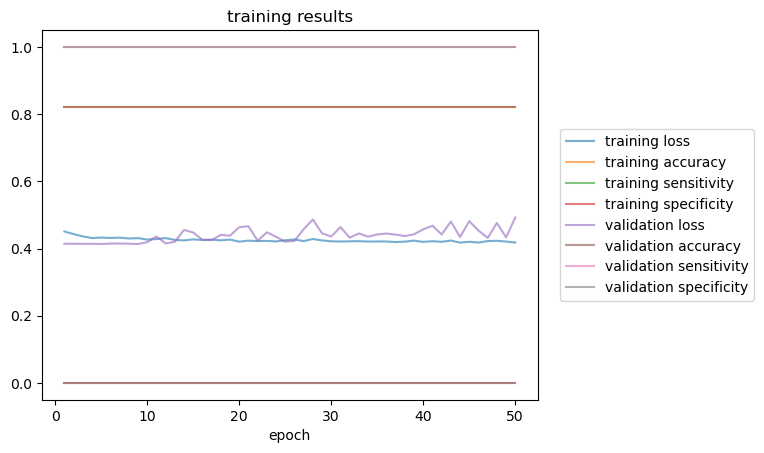

[GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
), 0.8944, 1.0, 0.0, 0.856, 1.0, 0.0]


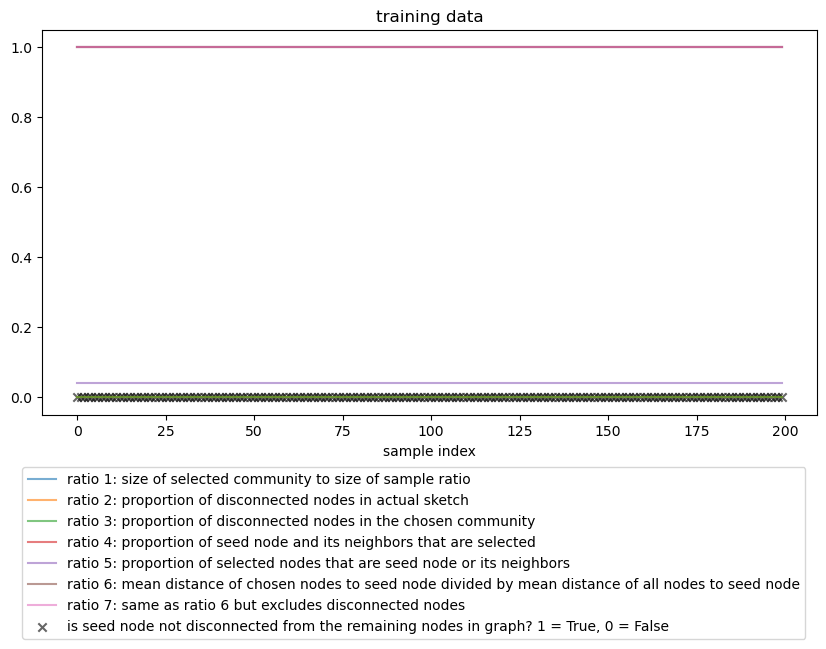

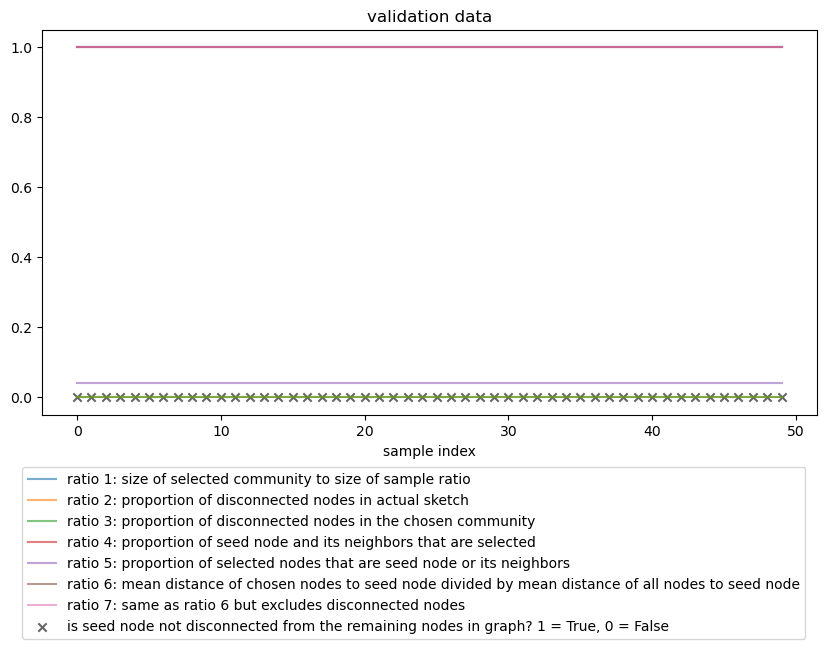

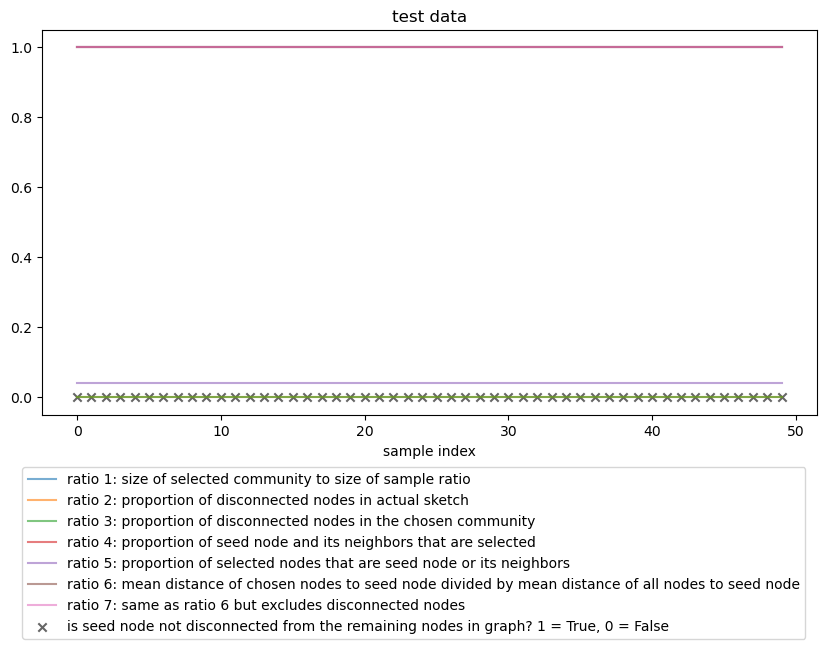

[[1.   0.   0.   1.   0.04 1.   1.  ]
 [1.   0.   0.   1.   0.04 1.   1.  ]
 [1.   0.   0.   1.   0.04 1.   1.  ]]


In [15]:
t1 = time.time()
samples = generateSamples_sketch_classification(200,50,50,10,4,randomAdjacencyMatrix,25,0.2,True,True)
t2 = time.time()
print(t2-t1)
#results = run(samples,'mlp','bce','adam',None,50)
#print(results)
#stats = evaluate(results[0],samples,classification=True)
#print(stats)

results = run(samples,'gcn','bce','adam',None,50)
print(results)
stats = evaluate(results[0],samples,classification=True)
print(stats)

0.8039164543151855
GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.3443, Training Accuracy: 0.8614, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4248, Validation Accuracy: 0.7816, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.3440, Training Accuracy: 0.8614, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4204, Validation Accuracy: 0.7816, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.3442, Training Accuracy: 0.8614, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.4262, Validation Accuracy: 0.7816, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 040, Training Loss: 0.3443, Training Accuracy: 0.8614, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validatio

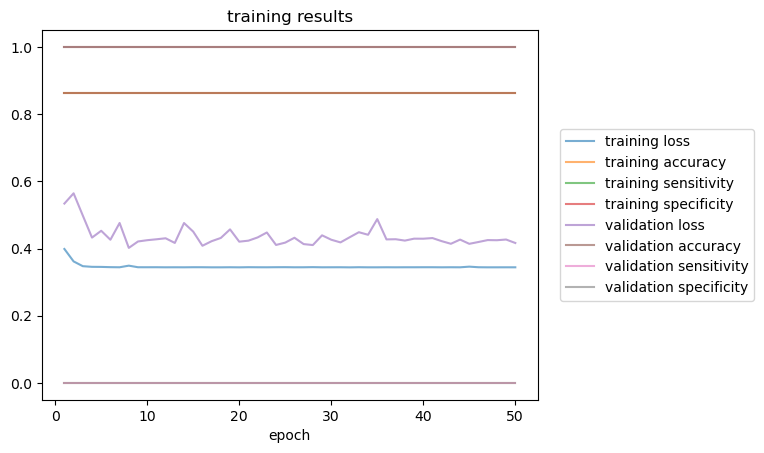

[GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
), 0.776, 0.0, 1.0, 0.7816, 0.0, 1.0]


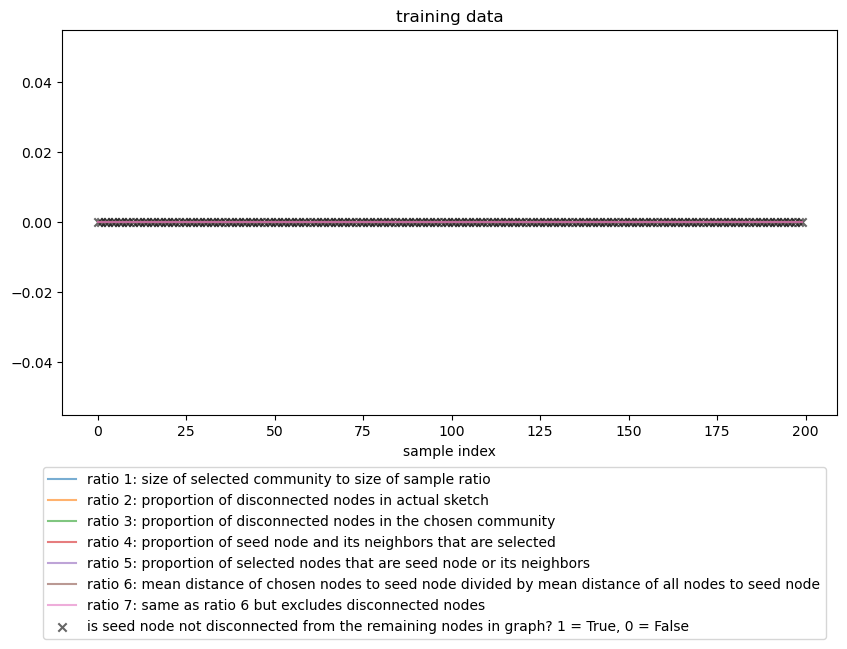

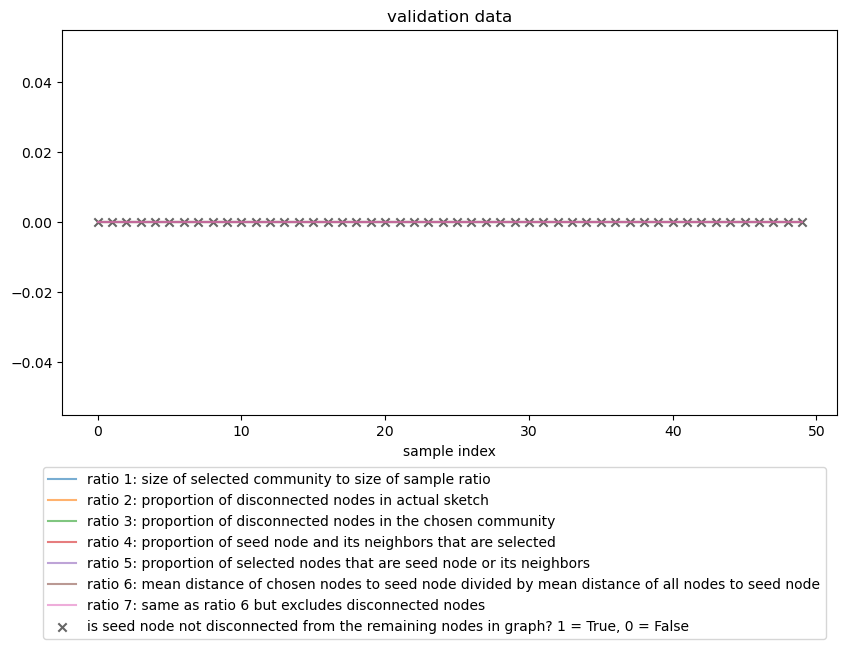

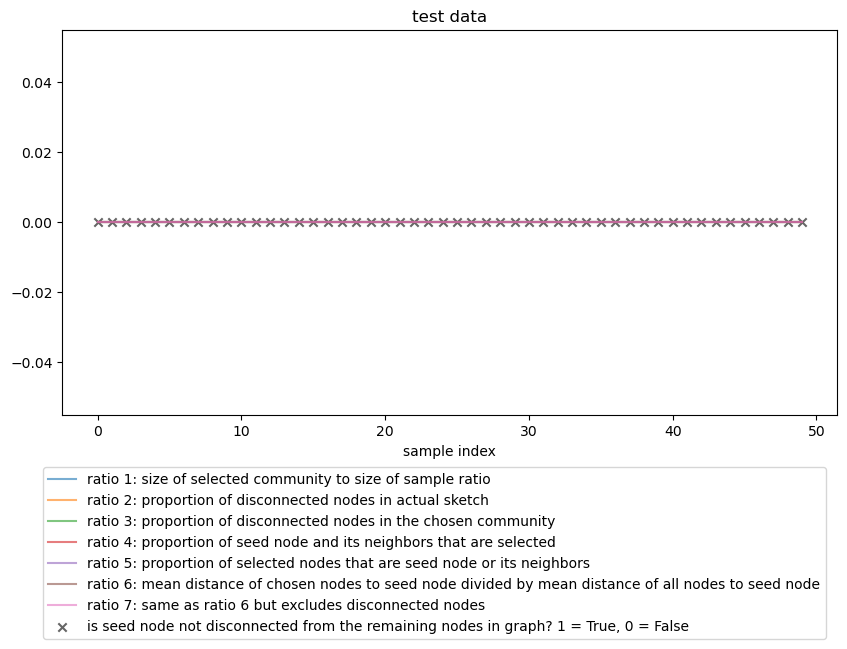

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [16]:
t1 = time.time()
samples = generateSamples_sketch_classification(200,50,50,10,4,ChungLuGraph,25,3)
t2 = time.time()
print(t2-t1)
#results = run(samples,'mlp','bce','adam',None,50)
#print(results)
#stats = evaluate(results[0],samples,classification=True)
#print(stats)

results = run(samples,'gcn','bce','adam',None,50)
print(results)
stats = evaluate(results[0],samples,classification=True)
print(stats)

0.7899830341339111
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 1)
)


Epoch: 010, Training Loss: 0.9344, Training MSE: 2.9650, Validation Loss: 0.8582, Validation MSE: 2.6960
Epoch: 020, Training Loss: 0.9344, Training MSE: 2.9650, Validation Loss: 0.8580, Validation MSE: 2.6960
Epoch: 030, Training Loss: 0.9344, Training MSE: 2.9650, Validation Loss: 0.8580, Validation MSE: 2.6960
Epoch: 040, Training Loss: 0.9344, Training MSE: 2.9650, Validation Loss: 0.8580, Validation MSE: 2.6960
Epoch: 050, Training Loss: 0.9344, Training MSE: 2.9650, Validation Loss: 0.8580, Validation MSE: 2.6960
Test Loss: 0.747587, Test MSE: 2.862667


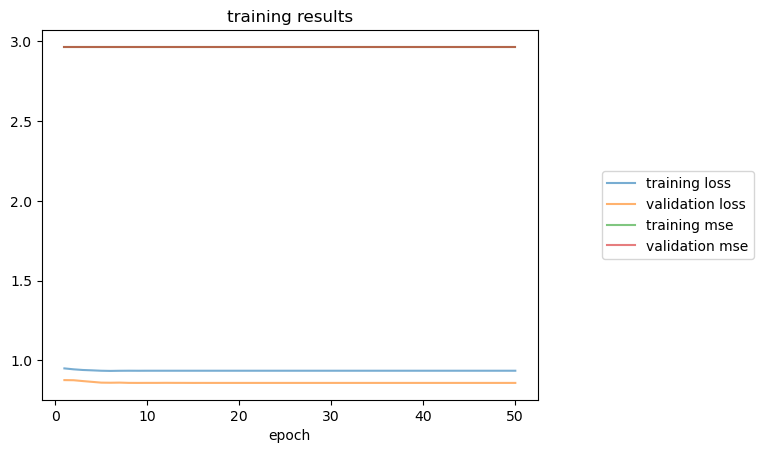

[GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 1)
), 2.8626666666666667, 2.696]
Prediction to true distance ratio is 0.0 for all samples in training data.
Prediction to true distance ratio is 0.0 for all samples in validation data.
Prediction to true distance ratio is 0.0 for all samples in test data.
[[0.]
 [0.]
 [0.]]


In [17]:
t1 = time.time()
samples = generateSamples_sketch_regression(200,50,50,10,4,ErdosRenyiGraph,15,0.3)
t2 = time.time()
print(t2-t1)
#results = run(samples,'mlp','mse','adam',None,50)
#print(results)
#stats = evaluate(results[0],samples,classification=False)
#print(stats)

results = run(samples,'gcn','mse','adam',None,50)
print(results)
stats = evaluate(results[0],samples,classification=False)
print(stats)

4.792968511581421
GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 1)
)
Epoch: 010, Training Loss: 0.2585, Training MSE: 0.6670, Validation Loss: 0.1543, Validation MSE: 0.4397
Epoch: 020, Training Loss: 0.2585, Training MSE: 0.6670, Validation Loss: 0.1544, Validation MSE: 0.4397
Epoch: 030, Training Loss: 0.2585, Training MSE: 0.6670, Validation Loss: 0.1544, Validation MSE: 0.4397
Epoch: 040, Training Loss: 0.2585, Training MSE: 0.6670, Validation Loss: 0.1544, Validation MSE: 0.4397
Epoch: 050, Training Loss: 0.2585, Training MSE: 0.6670, Validation Loss: 0.1544, Validation MSE: 0.4397
Test Loss: 0.142930, Test MSE: 0.450421


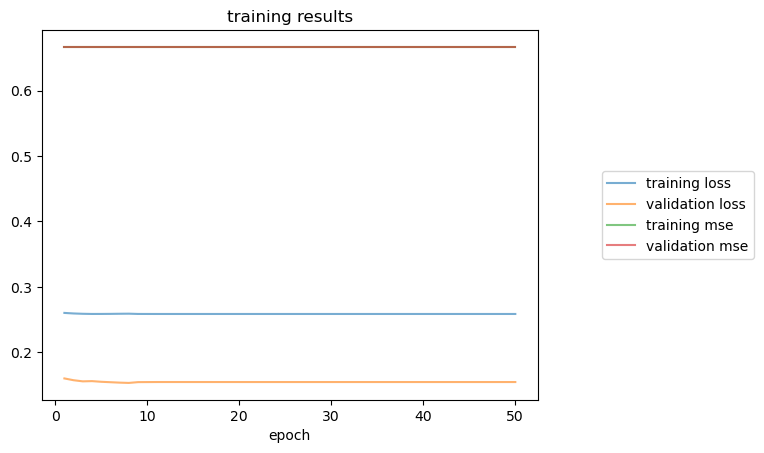

[GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 1)
), 0.45042085094607953, 0.439661222904366]
Prediction to true distance ratio is 0.0 for all samples in training data.
Prediction to true distance ratio is 0.0 for all samples in validation data.
Prediction to true distance ratio is 0.0 for all samples in test data.
[[0.]
 [0.]
 [0.]]


In [18]:
t1 = time.time()
samples = generateSamples_sketch_regression(200,50,50,10,4,randomAdjacencyMatrix,25,0.2,True,True)
t2 = time.time()
print(t2-t1)
#results = run(samples,'mlp','mse','adam',None,50)
#print(results)
#stats = evaluate(results[0],samples,classification=False)
#print(stats)

results = run(samples,'gcn','mse','adam',None,50)
print(results)
stats = evaluate(results[0],samples,classification=False)
print(stats)

0.7617032527923584
GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 1)
)
Epoch: 010, Training Loss: 0.2670, Training MSE: 0.2862, Validation Loss: 0.1379, Validation MSE: 0.1472
Epoch: 020, Training Loss: 0.2670, Training MSE: 0.2862, Validation Loss: 0.1379, Validation MSE: 0.1472
Epoch: 030, Training Loss: 0.2670, Training MSE: 0.2862, Validation Loss: 0.1379, Validation MSE: 0.1472
Epoch: 040, Training Loss: 0.2670, Training MSE: 0.2862, Validation Loss: 0.1379, Validation MSE: 0.1472
Epoch: 050, Training Loss: 0.2670, Training MSE: 0.2862, Validation Loss: 0.1379, Validation MSE: 0.1472
Test Loss: 0.215843, Test MSE: 0.232000


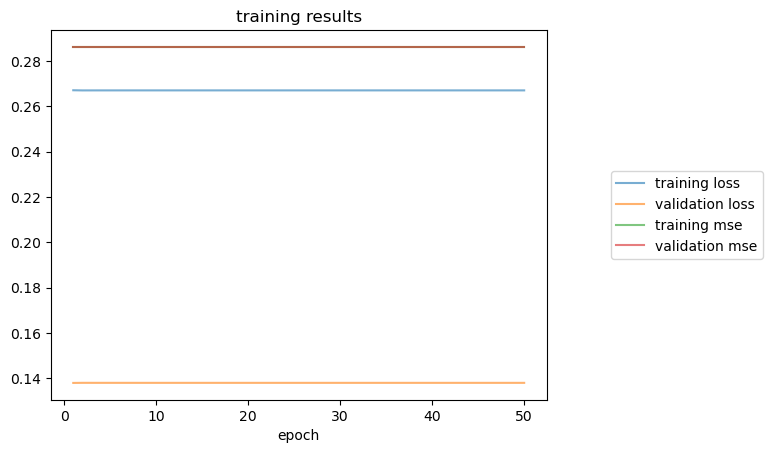

[GCN(
  (conv1): GCNConv(25, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 1)
), 0.232, 0.1472]
Prediction to true distance ratio is 0.0 for all samples in training data.
Prediction to true distance ratio is 0.0 for all samples in validation data.
Prediction to true distance ratio is 0.0 for all samples in test data.
[[0.]
 [0.]
 [0.]]


In [19]:
t1 = time.time()
samples = generateSamples_sketch_regression(200,50,50,10,4,ChungLuGraph,25,3)
t2 = time.time()
print(t2-t1)
#results = run(samples,'mlp','mse','adam',None,50)
#print(results)
#stats = evaluate(results[0],samples,classification=False)
#print(stats)

results = run(samples,'gcn','mse','adam',None,50)
print(results)
stats = evaluate(results[0],samples,classification=False)
print(stats)